In [1]:
import sys
sys.path.insert(0, "../")
from spot_master.unet import data
from spot_master.unet.model import UNet
from spot_master.unet.utils import DiceLoss, RMSELoss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
import numpy as np

/opt/anaconda/envs/cuda/lib/python3.10/site-packages/tqdm-4.65.0-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_transforms = Compose([
    data.RandomHorizontalFlip(),
    data.RandomRotation(),
    data.ToTensorWrapper(),
])

In [8]:
train_dataset = data.FISHSpotsDataset(
    meta_csv="meta_train.csv", root_dir="../FISH_spots",
    transform=None)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

test_dataset = data.FISHSpotsDataset(
    meta_csv="meta_test.csv", root_dir="../FISH_spots")
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1, 1, 4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
rmse_loss = RMSELoss()
dice_loss = DiceLoss()

def criterion(pred, target):
    loss_dice = dice_loss(pred, target)
    loss_rmse = rmse_loss(pred, target)
    return 0.6 * loss_dice + 0.4 * loss_rmse

In [10]:
# TensorBoard
writer = SummaryWriter("runs/fish_spots_experiment")

In [11]:
# Train
num_epochs = 50
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for idx, batch in enumerate(train_loader):
        images = batch["image"].to(device, dtype=torch.float)
        masks = batch["mask"].to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        if idx % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Batch: {idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
            writer.add_scalar("Loss/train_batch", loss.item(), epoch * len(train_loader) + idx)
            img = images[0, 0].cpu().numpy()
            img = np.stack((img,)*3, axis=0)
            # normalize to 0-255
            img = (img - img.min()) / (img.max() - img.min()) * 255
            # record images
            writer.add_image("Image/input", images[0], epoch * len(train_loader) + idx)
            writer.add_image("Image/mask", masks[0], epoch * len(train_loader) + idx)
            writer.add_image("Image/pred", outputs[0], epoch * len(train_loader) + idx)

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    writer.add_scalar("Loss/train", epoch_loss, epoch)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device, dtype=torch.float)
            masks = batch["mask"].to(device, dtype=torch.float)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    writer.add_scalar("Loss/val", val_loss, epoch)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved with Val Loss: {val_loss:.4f}")

writer.close()

Epoch: 1/50, Batch: 1/269, Loss: 0.6576
Epoch: 1/50, Batch: 11/269, Loss: 0.5111
Epoch: 1/50, Batch: 21/269, Loss: 0.3785
Epoch: 1/50, Batch: 31/269, Loss: 0.3315
Epoch: 1/50, Batch: 41/269, Loss: 0.3384
Epoch: 1/50, Batch: 51/269, Loss: 0.3039
Epoch: 1/50, Batch: 61/269, Loss: 0.2802
Epoch: 1/50, Batch: 71/269, Loss: 0.3017
Epoch: 1/50, Batch: 81/269, Loss: 0.2499
Epoch: 1/50, Batch: 91/269, Loss: 0.2702
Epoch: 1/50, Batch: 101/269, Loss: 0.2433
Epoch: 1/50, Batch: 111/269, Loss: 0.2934
Epoch: 1/50, Batch: 121/269, Loss: 0.2416
Epoch: 1/50, Batch: 131/269, Loss: 0.2301
Epoch: 1/50, Batch: 141/269, Loss: 0.1872
Epoch: 1/50, Batch: 151/269, Loss: 0.1565
Epoch: 1/50, Batch: 161/269, Loss: 0.1556
Epoch: 1/50, Batch: 171/269, Loss: 0.1652
Epoch: 1/50, Batch: 181/269, Loss: 0.1753
Epoch: 1/50, Batch: 191/269, Loss: 0.1594
Epoch: 1/50, Batch: 201/269, Loss: 0.1429
Epoch: 1/50, Batch: 211/269, Loss: 0.1676
Epoch: 1/50, Batch: 221/269, Loss: 0.1665
Epoch: 1/50, Batch: 231/269, Loss: 0.1502
Epo

In [31]:
t1['image'].shape

torch.Size([8, 1, 512, 512])

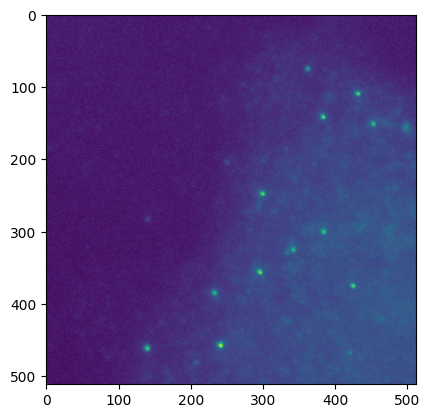

In [43]:
for t1 in train_loader:
    break
plt.imshow(t1['image'][0].squeeze().numpy())